In [1]:
# Try to write a checkerboard Hubbard model with 1 cluster and four orbitals per cluster
from itertools import product

import numpy as np
from risb_sparse.embedding import SolveEmbeddingSparse,EmbeddingSparseDummy
from risb_sparse.solve_lattice_ED import LatticeSolver
from risb_sparse.helpers import block_to_full, get_h0_kin_k
from risb_sparse.helpers_triqs import get_h0_loc
from risb_sparse.kweight import SmearingKWeight


def get_h0_k(t=2,t1 = 0.5, nkx = 20, spin_names=None):
    # return dictionary with h0_k for each spin channel, h0_k is shaped as (nk,n_orbitals*n_clusters)
    if spin_names is None:
        spin_names = ["up", "dn"]
    na = 1  # only 1 cluster for t>2t1
    n_orb = 4  # Number of orbitals/sites per cluster
    phi = np.pi / 3.0 
    n_k = nkx**2

    # Build shifted 2D mesh 
    mesh = np.empty(shape=(n_k, 2))
    for idx, coords in enumerate(product(range(nkx), range(nkx))):
        mesh[idx, 0] = coords[0]/nkx + 0.5/nkx
        mesh[idx, 1] = coords[1]/nkx + 0.5/nkx
    # Unit cell lattice vectors (Square lattice)
    R1 = (1,0)
    R2 = (0,1)
    R = np.array((R1, R2)).T
    # Bravais lattice vectors
    G = 2.0 * np.pi * np.linalg.inv(R).T

    h0_k = np.zeros([n_k,na,na,n_orb,n_orb], dtype=complex)
    # construct inequivalent block matrix structure, in Square lattice side, na is 1
    #for k, i, j, m, mm in product(range(n_k), range(na), range(na), range(n_orb), range(n_orb)):
    # define a transformation matrix from AO to MO basis
    AtM_trans = np.array([
    [ 1/2,  1/2,  1/2,  1/2],
    [ 1/2,  1/2, -1/2, -1/2],
    [ 1/2, -1/2,  1/2, -1/2],
    [ 1/2, -1/2, -1/2,  1/2]], dtype= complex)
    for k in range(n_k):
        kay = np.dot(G, mesh[k,:])
        # dispersion term for a local cluster
        h0_k[k,0,0,:,:] += np.diag([3*t,-t,-t,-t])
        # Dispersion terms between clusters from different site
        h0_k_AO = np.array([
            [0,0,t1*np.exp(1j*kay@R2),0],
            [0,0,0,t1*np.exp(-1j*kay@R1)],
            [t1*np.exp(-1j*kay@R2),0,0,0],
            [0,t1*np.exp(1j*kay@R1),0,0]])
        h0_k[k,0,0,:,:] += AtM_trans.conj().T @ h0_k_AO @ AtM_trans
    
    # Get rid of the inequivalent block structure
    h0_k_out = {}
    for bl in spin_names:
        h0_k_out[bl] = block_to_full(h0_k)  # transform into a (nk, n_cluster*n_orb, n_cluster*n_orb) matrix
    return h0_k_out

In [2]:
def get_hubb_tetra(U=0,spin_names=["up","dn"]): # get the hubbard interaction in tetra basis
    # note that tk terms already included in h0_k, so we set t = 0 here.
    n_orb = 4   
    # compute the U terms under tetra basis
    U_trans = np.array([
    [ 1/2,  1/2,  1/2,  1/2],
    [ 1/2,  1/2, -1/2, -1/2],
    [ 1/2, -1/2,  1/2, -1/2],
    [ 1/2, -1/2, -1/2,  1/2]], dtype= complex) # transformation matrix 
    V_AO = np.zeros((4,4,4,4)) # Interaction tensor
    for i in range(n_orb):
        V_AO[i,i,i,i] = U
    V_tetra = np.einsum("ia,jb,kc,ld,ijkl->abcd",U_trans.conj(), U_trans.conj(),U_trans,U_trans,V_AO)

    return V_tetra

# Setup problem and gf_struct for each inequivalent trimer cluster
n_clusters = 1
n_orb = 4
spin_names = ["up", "dn"]

# Setup non-interacting Hamiltonian matrix on the lattice
t1 = 0.5
nkx = 20
h0_k = get_h0_k(t1=t1, nkx=nkx, spin_names=spin_names)
V_tetra = get_hubb_tetra(U = 2)

# Set up class to work out k-space integration weights
beta = 30  # inverse temperature
n_target = 3  # half-filling of lower three bands
kweight = SmearingKWeight(beta=beta, n_target=n_target,method="methfessel-paxton")

# Set up gf_structure of clusters
gf_struct_molecule = [
    ("up_A", 1),
    ("up_T", 3),
    ("dn_A", 1),
    ("dn_T", 3),
]
gf_struct_molecule_mapping = { # map: {block_proj: block_h0k}
    "up_A": "up",
    "up_T": "up",
    "dn_A": "dn",
    "dn_T": "dn",
}
gf_struct = [gf_struct_molecule for _ in range(n_clusters)]
gf_struct_mapping = [gf_struct_molecule_mapping for _ in range(n_clusters)] # used when h0_k does not have the same block structures as the projectors


# Make projectors onto each trimer cluster
# each cluster has its own projector, with a dict as {block_name: projector}
projectors = [{} for i in range(n_clusters)] 
for i in range(n_clusters):
    projectors[i]["up_A"] = np.eye(n_clusters * n_orb)[0 + i * n_orb : 1 + i * n_orb, :]
    projectors[i]["dn_A"] = np.eye(n_clusters * n_orb)[0 + i * n_orb : 1 + i * n_orb, :]
    projectors[i]["up_T"] = np.eye(n_clusters * n_orb)[
        1 + i * n_orb : 4 + i * n_orb, :
    ]
    projectors[i]["dn_T"] = np.eye(n_clusters * n_orb)[
        1 + i * n_orb : 4 + i * n_orb, :]


In [3]:
# Set up embedding solvers
embedding = [SolveEmbeddingSparse(V_tetra, gf_struct[0])]
for _ in range(n_clusters - 1):
    embedding.append(EmbeddingSparseDummy(embedding[0]))  

def symmetries(A): # enforce symmetries
    n_clusters = len(A)
    for i in range(n_clusters):
        # Paramagnetic constraint
        for key in ["A", "T"]:
            A[i][f"up_{key}"] = 0.5 * (A[i][f"up_{key}"] + A[i][f"dn_{key}"])
            A[i][f"dn_{key}"] = A[i][f"up_{key}"]
        '''
        # Enforce cubic rotational symmetry in the T subspace (average over T1, T2, T3),(if assuming orbital symmetry)
        T_avg = (A[i]["up_T1"] + A[i]["up_T2"] + A[i]["up_T3"]) / 3
        for key in ["T1", "T2", "T3"]:
            A[i][f"up_{key}"] = T_avg
            A[i][f"dn_{key}"] = T_avg
        '''

    return A

# Setup RISB solver class
S = LatticeSolver(
    h0_k=h0_k,
    gf_struct=gf_struct,
    embedding=embedding,
    update_weights=kweight.update_weights,
    projectors=projectors,
    symmetries=[symmetries],
    gf_struct_mapping=gf_struct_mapping,
)

In [4]:
# Solve
S.solve(tol=1e-4,one_shot=False,test = False)

# Print out some interesting observables
with np.printoptions(formatter={"float": "{: 0.4f}".format}):
    for i in range(S.n_clusters):
        print(f"Cluster {i}:")
        for bl, Z in S.Z[i].items():
            print(f"Quasiaprticle weight Z[{bl}] = \n{Z}")
            print(np.shape(Z))
        for bl, Lambda in S.Lambda[i].items():
            print(f"Correlation potential Lambda[{bl}] = \n{Lambda}")

Cluster 0:
Quasiaprticle weight Z[up_A] = 
[[0.90966502+2.45057056e-32j]]
(1, 1)
Quasiaprticle weight Z[up_T] = 
[[ 8.38147593e-01-5.53235041e-30j -1.79472200e-18+1.42292965e-17j
   1.64811601e-18+4.25700050e-19j]
 [-1.79472200e-18-1.42292965e-17j  8.34798231e-01-1.90245206e-29j
   1.02877968e-16+8.17628102e-19j]
 [ 1.64811601e-18-4.25700050e-19j  1.02877968e-16-8.17628102e-19j
   8.38147593e-01+2.25357469e-29j]]
(3, 3)
Quasiaprticle weight Z[dn_A] = 
[[0.90966502+2.45057056e-32j]]
(1, 1)
Quasiaprticle weight Z[dn_T] = 
[[ 8.38147593e-01-5.53235041e-30j -1.79472200e-18+1.42292965e-17j
   1.64811601e-18+4.25700050e-19j]
 [-1.79472200e-18-1.42292965e-17j  8.34798231e-01-1.90245206e-29j
   1.02877968e-16+8.17628102e-19j]
 [ 1.64811601e-18-4.25700050e-19j  1.02877968e-16-8.17628102e-19j
   8.38147593e-01+2.25357469e-29j]]
(3, 3)
Correlation potential Lambda[up_A] = 
[[5.89089672+0.j]]
Correlation potential Lambda[up_T] = 
[[-1.28218735e+00+0.j -3.95212385e-15+0.j  5.46792862e-16+0.j]
 [-3.

In [12]:
#######################################################################################
#---------------------Build high symmetry paths for band structure--------------------#
#######################################################################################
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt

def find_high_symmetry_path(mesh: np.ndarray, R: np.ndarray, points_per_segment: List[int]) -> Tuple[List[int], np.ndarray]:
    """
    Construct X, Gamma, Y, M, X path with unique indices from a shifted mesh.

    Parameters
    ----------
    mesh : ndarray of shape (n_k, 2)
        Shifted mesh in reduced coordinates
    R : ndarray of shape (2, 2)
        Lattice vectors as column vectors
    points_per_segment : List[int]
        List of number of interpolation points per segment

    Returns
    -------
    path_indices : List[int]
        Indices into mesh of closest k-points along path
    k_path : ndarray of shape (n_points, 2)
        Cartesian k-points along path
    """

    G = 2 * np.pi * np.linalg.inv(R).T  # reciprocal lattice vectors
    k_points = mesh @ G                # shape (n_k, 2)

    # High symmetry points
    Gamma = np.array([0, 0])
    X = np.array([np.pi, 0])
    M = np.array([np.pi, np.pi])
    Y = np.array([0, np.pi])

    # Define path segments
    high_sym_points = [X, Gamma, Y, M, X]

    # Interpolate each segment with corresponding number of points
    k_interp = []
    for i in range(len(high_sym_points) - 1):
        start = high_sym_points[i]
        end = high_sym_points[i + 1]
        n_pts = points_per_segment[i]
        seg = np.linspace(start, end, n_pts, endpoint=False)
        k_interp.append(seg)
    k_interp = np.vstack(k_interp)

    # Find closest mesh index for each point
    path_indices = []
    used_indices = set()
    for pt in k_interp:
        dists = np.linalg.norm(k_points - pt, axis=1)
        idx = np.argmin(dists)
        path_indices.append(idx)
        used_indices.add(idx)

    # Append final Gamma point
    final_idx = np.argmin(np.linalg.norm(k_points - Gamma, axis=1))
    path_indices.append(final_idx)

    return path_indices, k_points[path_indices]

# Build up the mesh
nkx = 20 # to plot quasi-particle bands, this should be consistent with mesh built in the solving process
n_k = nkx**2  # total number of k-points
# Build shifted 2D mesh
mesh = np.empty(shape=(n_k, 2))
for idx, coords in enumerate(product(range(nkx), range(nkx))):
    mesh[idx, 0] = coords[0] / nkx + 0.5 / nkx
    mesh[idx, 1] = coords[1] / nkx + 0.5 / nkx
# Unit cell lattice vectors
R1 = (1,0)
R2 = (0,1)
R = np.array((R1, R2)) # the definition is different from h0_k

# Find high symmetry path
point_list = [nkx,nkx,nkx,nkx] 
path_indices, _ = find_high_symmetry_path(mesh, R, point_list)

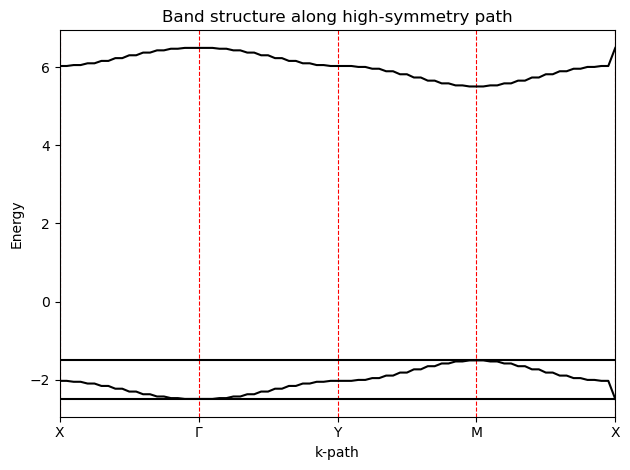

In [13]:
##############################################################################
#---------------------Plot the non-interacting bands-------------------------#
##############################################################################
# non-interacting energies
band_energys = []
spin_names = ["up", "dn"]
h0_k = get_h0_k(nkx=nkx, spin_names=spin_names)
all_bands = []
for idx in range(n_k):
    eband, evec = np.linalg.eigh(h0_k["dn"][idx])
    all_bands.append(np.sort(eband))
for idx in path_indices:
    band_energys.append(all_bands[idx])
band_energys = np.array(band_energys)  # shape: (N_k, N_band)
#print(band_energys.shape)
k_path = np.arange(len(band_energys))

# Figure settings
fig, ax = plt.subplots() 
for band in range(band_energys.shape[1]):
    plt.plot(k_path, band_energys[:, band], color="black")

plt.xlabel("k-path")
plt.ylabel("Energy")
ax.set_xticks([0, nkx, 2*nkx, 3*nkx, 4*nkx])
ax.set_xticklabels(['X',r'$\Gamma$', 'Y', 'M', 'X'])
plt.grid(axis='x',c='r',linestyle='--')
plt.xlim(0,4*nkx)
plt.title("Band structure along high-symmetry path")
plt.tight_layout()
plt.show()

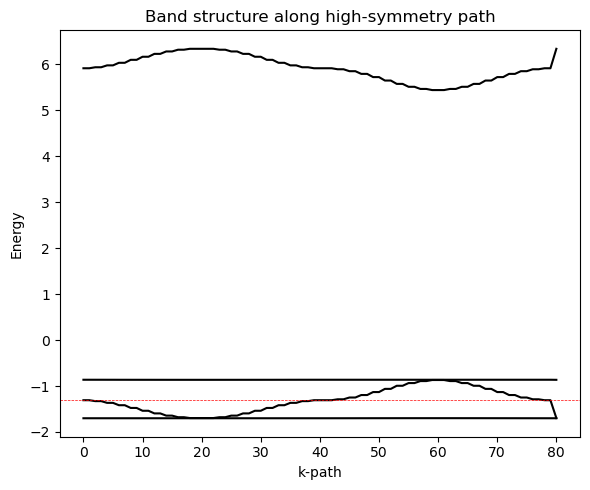

In [14]:
################################################################################################
#----------------------Plot the quasiparticle bands after solving------------------------------#
################################################################################################
band_energys = []
for idx in path_indices:
    #band_energys.append(np.sort(np.concatenate([S.energies_qp['up'][idx,:],S.energies_qp['dn'][idx,:]],axis =0)))
    band_energys.append(np.sort(S.energies_qp['up'][idx,:]))

band_energys = np.array(band_energys)  # shape: (N_k, N_band)
k_path = np.arange(len(band_energys))

# begin plot
plt.figure(figsize=(6, 5))
for band in range(band_energys.shape[1]):
    plt.plot(k_path, band_energys[:, band], color="black")


plt.axhline(y=kweight.mu, color='red', linestyle='--', linewidth=0.5)  #fermi-surface

plt.ylabel("Energy")
plt.xlabel("k-path")
plt.title("Band structure along high-symmetry path")
plt.tight_layout()
plt.show()


In [15]:
# calculate the variation of QP weight Z with respect to U
import matplotlib.pyplot as plt
from risb_sparse.kweight.from_triqs_hartree import update_mu

def plot_Z_vs_U(U_arr):
    Z_A = []
    Z_T = [] # for T orbitals, we take the trace of the qp weight matrix
    U_list = []
    for U in U_arr:
        V_tetra = get_hubb_tetra(U) # interaction tensor
        # Set up embedding solvers
        embedding = [SolveEmbeddingSparse(V_tetra, gf_struct[0])]
        for _ in range(n_clusters - 1):
            embedding.append(EmbeddingSparseDummy(embedding[0]))  
        
        # Setup RISB solver class
        S = LatticeSolver(
            h0_k=h0_k,
            gf_struct=gf_struct,
            embedding=embedding,
            update_weights=kweight.update_weights,
            projectors=projectors,
            symmetries=[symmetries],
            gf_struct_mapping=gf_struct_mapping,
        )

        try:
            S.solve(tol=1e-4)
            # Calculate the Z values 
            Z_val_A = S.Z[0]["up_A"][0, 0]
            Z_val_T = 1/3 * np.trace(S.Z[0]["up_T"]) # totally three orbitals
            
            if Z_val_A < 1e-3 or Z_val_T < 1e-3: # mott transition may cause singularities
                break
            
            U_list.append(U)
            Z_A.append(Z_val_A)
            Z_T.append(Z_val_T)
            

            print(f"U={U}")
            print(f"Z_A = {Z_val_A}")
            print(f"Z_T = {Z_val_T}")
            print(f"Z_T_mat = {S.Z[0]['up_T']}")
            print("-"*40)
        except ValueError as e:
            print(f"[ERROR] Failed at U = {U}")
            if hasattr(kweight, "energies") and hasattr(kweight, "beta"):
                energies = kweight.energies
                print(energies)
                beta = kweight.beta
                e_min, e_max = np.inf, -np.inf
                for en in energies.values():
                    e_min = min(e_min, en.min())
                    e_max = max(e_max, en.max())
                e_min  = e_min-2
                e_max = e_max +2 
                print(f"e_min = {e_min}, e_max = {e_max}")
                try:
                    def target_function(mu,energies=energies, beta=beta):
                        n = 0
                        for en in energies.values():
                            n += np.sum(kweight.smear_function(en,beta,mu))/(30**2)
                        return n - n_target
                    print(f"f(e_min) = {target_function(e_min)}")
                    print(f"f(e_max) = {target_function(e_max)}")
                except Exception as ee:
                    print(f"Failed to evaluate f(e_min) or f(e_max): {ee}")
            raise e  # optional: re-raise for visibility
        
    fig, axis = plt.subplots(1, 1)
    axis.plot(U_list, np.real(Z_A), "-ok")
    axis.plot(U_list, np.real(Z_T), "-^b")
    axis.legend(["A", "T"])
    axis.set_xlabel(r"$U$")
    axis.set_ylabel(r"$Z$")
    plt.show()


U=0.0
Z_A = (1.000000000000003+4.132620362693562e-32j)
Z_T = (1.000000000000005+0j)
Z_T_mat = [[ 1.00000000e+00+0.00000000e+00j -2.91641462e-21-5.44957610e-20j
  -2.69516696e-20-6.12408415e-21j]
 [-2.91641462e-21+5.44957610e-20j  1.00000000e+00+0.00000000e+00j
  -1.18421180e-17-2.28149680e-16j]
 [-2.69516696e-20+6.12408415e-21j -1.18421180e-17+2.28149680e-16j
   1.00000000e+00+0.00000000e+00j]]
----------------------------------------
U=0.5
Z_A = (0.9935339318086138+4.780526330789224e-33j)
Z_T = (0.9894975305290927+0j)
Z_T_mat = [[ 9.89574369e-01+0.00000000e+00j  8.36057251e-19-1.10342690e-17j
  -1.70144189e-17+1.55193415e-18j]
 [ 8.36057251e-19+1.10342690e-17j  9.89343853e-01+0.00000000e+00j
   3.82307271e-16+3.48193867e-16j]
 [-1.70144189e-17-1.55193415e-18j  3.82307271e-16-3.48193867e-16j
   9.89574369e-01+0.00000000e+00j]]
----------------------------------------
U=1.0
Z_A = (0.9748080304761476+2.7658739013140783e-32j)
Z_T = (0.9584281372661+0j)
Z_T_mat = [[ 9.58728124e-01+0.000000

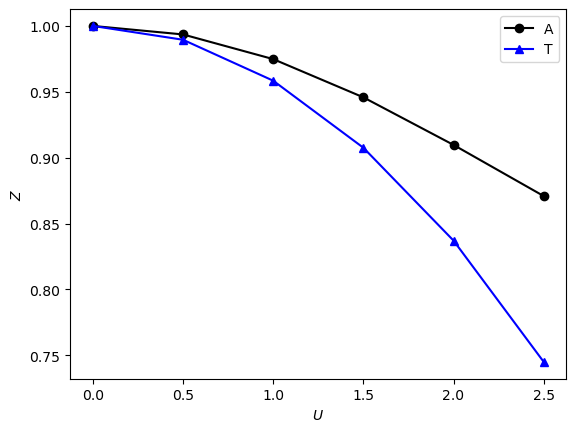

In [17]:
U_arr = np.arange(0, 3, 0.5)
plot_Z_vs_U(U_arr)

In [18]:
# calculate the variation of QP weight Z with respect to U
import matplotlib.pyplot as plt
from risb_sparse.kweight.from_triqs_hartree import update_mu

def plot_S_vs_U(U_arr):
    S_A = []
    S_T = []
    U_list = []
    for U in U_arr:
        V_tetra = get_hubb_tetra(U) # interaction tensor
        # Set up embedding solvers
        embedding = [SolveEmbeddingSparse(V_tetra, gf_struct[0])]
        for _ in range(n_clusters - 1):
            embedding.append(EmbeddingSparseDummy(embedding[0]))  
        
        # Setup RISB solver class
        S = LatticeSolver(
            h0_k=h0_k,
            gf_struct=gf_struct,
            embedding=embedding,
            update_weights=kweight.update_weights,
            projectors=projectors,
            symmetries=[symmetries],
            gf_struct_mapping=gf_struct_mapping,
        )

        try:
            S.solve(tol=1e-4)
            # Calculate the Z values 
            Z_val_A = S.Z[0]["up_A"][0, 0]
            Z_val_T = 1/3 * np.trace(S.Z[0]["up_T"]) # totally three orbitals
            
            if Z_val_A < 1e-5 and Z_val_T < 1e-5: # mott transition may cause singularities
                break

            # calculate effective spins
            S_val_A = embedding[0].get_Seff("up_A")
            S_val_T = embedding[0].get_Seff("up_T")

            U_list.append(U)
            S_A.append(S_val_A)
            S_T.append(S_val_T)
            

            print(f"U={U}")
            print(f"S_A = {S_val_A}")
            print(f"S_T = {S_val_T}")
            print("-"*40)
        except ValueError as e:
            print(f"[ERROR] Failed at U = {U}")
            if hasattr(kweight, "energies") and hasattr(kweight, "beta"):
                energies = kweight.energies
                print(energies)
                beta = kweight.beta
                e_min, e_max = np.inf, -np.inf
                for en in energies.values():
                    e_min = min(e_min, en.min())
                    e_max = max(e_max, en.max())
                e_min  = e_min-2
                e_max = e_max +2 
                print(f"e_min = {e_min}, e_max = {e_max}")
                try:
                    def target_function(mu,energies=energies, beta=beta):
                        n = 0
                        for en in energies.values():
                            n += np.sum(kweight.smear_function(en,beta,mu))/(30**2)
                        return n - n_target
                    print(f"f(e_min) = {target_function(e_min)}")
                    print(f"f(e_max) = {target_function(e_max)}")
                except Exception as ee:
                    print(f"Failed to evaluate f(e_min) or f(e_max): {ee}")
            raise e  # optional: re-raise for visibility
        
    fig, axis = plt.subplots(1, 1)
    axis.plot(U_list, np.real(S_A), "-ok")
    axis.plot(U_list, np.real(S_T), "-^b")
    axis.legend(["A", "T"])
    axis.set_xlabel(r"$U$")
    axis.set_ylabel(r"$S$")
    plt.show()


U=0.0
S_A = (0.0013472038022775967+0j)
S_T = (0.290996184674881+0j)
----------------------------------------
U=0.2
S_A = (0.0013640207874434651+0j)
S_T = (0.32337506257103965-1.6854758467520504e-17j)
----------------------------------------
U=0.4
S_A = (0.0014144744015289756+0j)
S_T = (0.3552489669335198+0j)
----------------------------------------
U=0.6000000000000001
S_A = (0.001498175589453421+0j)
S_T = (0.38676675393535076+0j)
----------------------------------------
U=0.8
S_A = (0.0016141031808296624+0j)
S_T = (0.41808482202320696-1.511601921185411e-17j)
----------------------------------------
U=1.0
S_A = (0.0017606160423381256+0j)
S_T = (0.4493635513894171+0j)
----------------------------------------
U=1.2000000000000002
S_A = (0.0019353215618308495+0j)
S_T = (0.4807744721915571-2.8299651349620276e-17j)
----------------------------------------
U=1.4000000000000001
S_A = (0.0021350335950607313+0j)
S_T = (0.5125231136476989+2.741228841249573e-17j)
---------------------------------

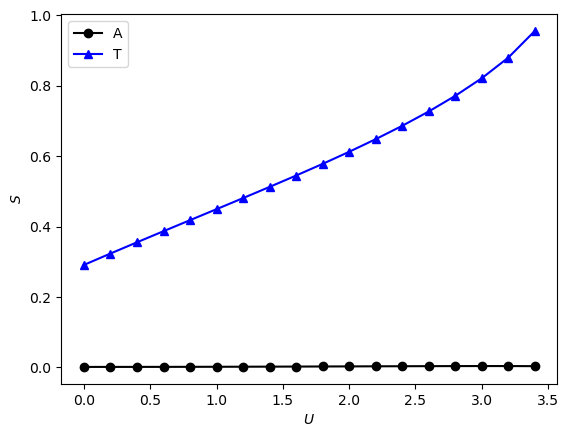

In [19]:
U_arr = np.arange(0, 3.6, 0.2)
plot_S_vs_U(U_arr)